# Tree-based methods 

In this lab, we'll consider the Pima Indians dataset, which primarly objective is to diagnostically predict whether female patients suffer from diabetes or not, based on a series of medical attributes. To this end, we'll be using several tree-based methods that were covered during the course lectures. 

Here are some info regarding the dataset's attributes :
  - Num_pregnant : The number of pregnancies the patient had. 
  - glucose_con : Patient's plasma glucsose concentration.
  - blood_pressure : Patient's dialostic blood pressure (mmHg).
  - triceps_thickness : Patient's triceps skin-fold thickness (mm).
  - insulin : Patient's 2-h serum insulin (mu U/mL).
  - bmi : Patient's body mass index (kg/m^2).
  - dpf : Patient's diabetes pedigree function.
  - age : Patient's age. 
  - diabetes : Whether the patient has diabetes (1) or not (0).

**Load the necessary libraries** 

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import math
from sklearn.pipeline import Pipeline 
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, BaggingClassifier, BaggingRegressor

**1) Load the dataset, get its general information, and check for missing values.** 

In [2]:
file = 'pima_indians_lab.csv'
df = pd.read_csv(file, index_col=0)
print(df.info())
print(df.head())
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Num_pregnant       750 non-null    float64
 1   glucose_con        755 non-null    float64
 2   blood_pressure     761 non-null    float64
 3   triceps_thickness  757 non-null    float64
 4   insulin            768 non-null    float64
 5   bmi                768 non-null    float64
 6   dpf                767 non-null    float64
 7   age                761 non-null    float64
 8   diabetes           768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 60.0 KB
None
   Num_pregnant  glucose_con  blood_pressure  triceps_thickness  insulin  \
0           6.0        148.0            72.0               35.0      0.0   
1           1.0         85.0            66.0               29.0      0.0   
2           8.0        183.0            64.0                0.0      0.0   
3       

# Decision Trees

**2) Select 'diabetes' as the target variable, and all the remaining columns as predictors. Create a pipeline containing the preprocessing steps (missing values imputer, scaler,...) and a Decision Tree classifier, which maximum depth should be set to 3 (through the 'max_depth' argument). Set the entropy as the split criterion. Do you think scaling the variables is necessary ?**

**Fit this pipeline to the data (do not split the dataset for the time being), and plot the decision tree. How do you interpret it ?** 

**You'll need the 'plot_tree' class from the sklearn library. You can access the pipeline's classifier using the 'named_steps['classifier']' attributes.**

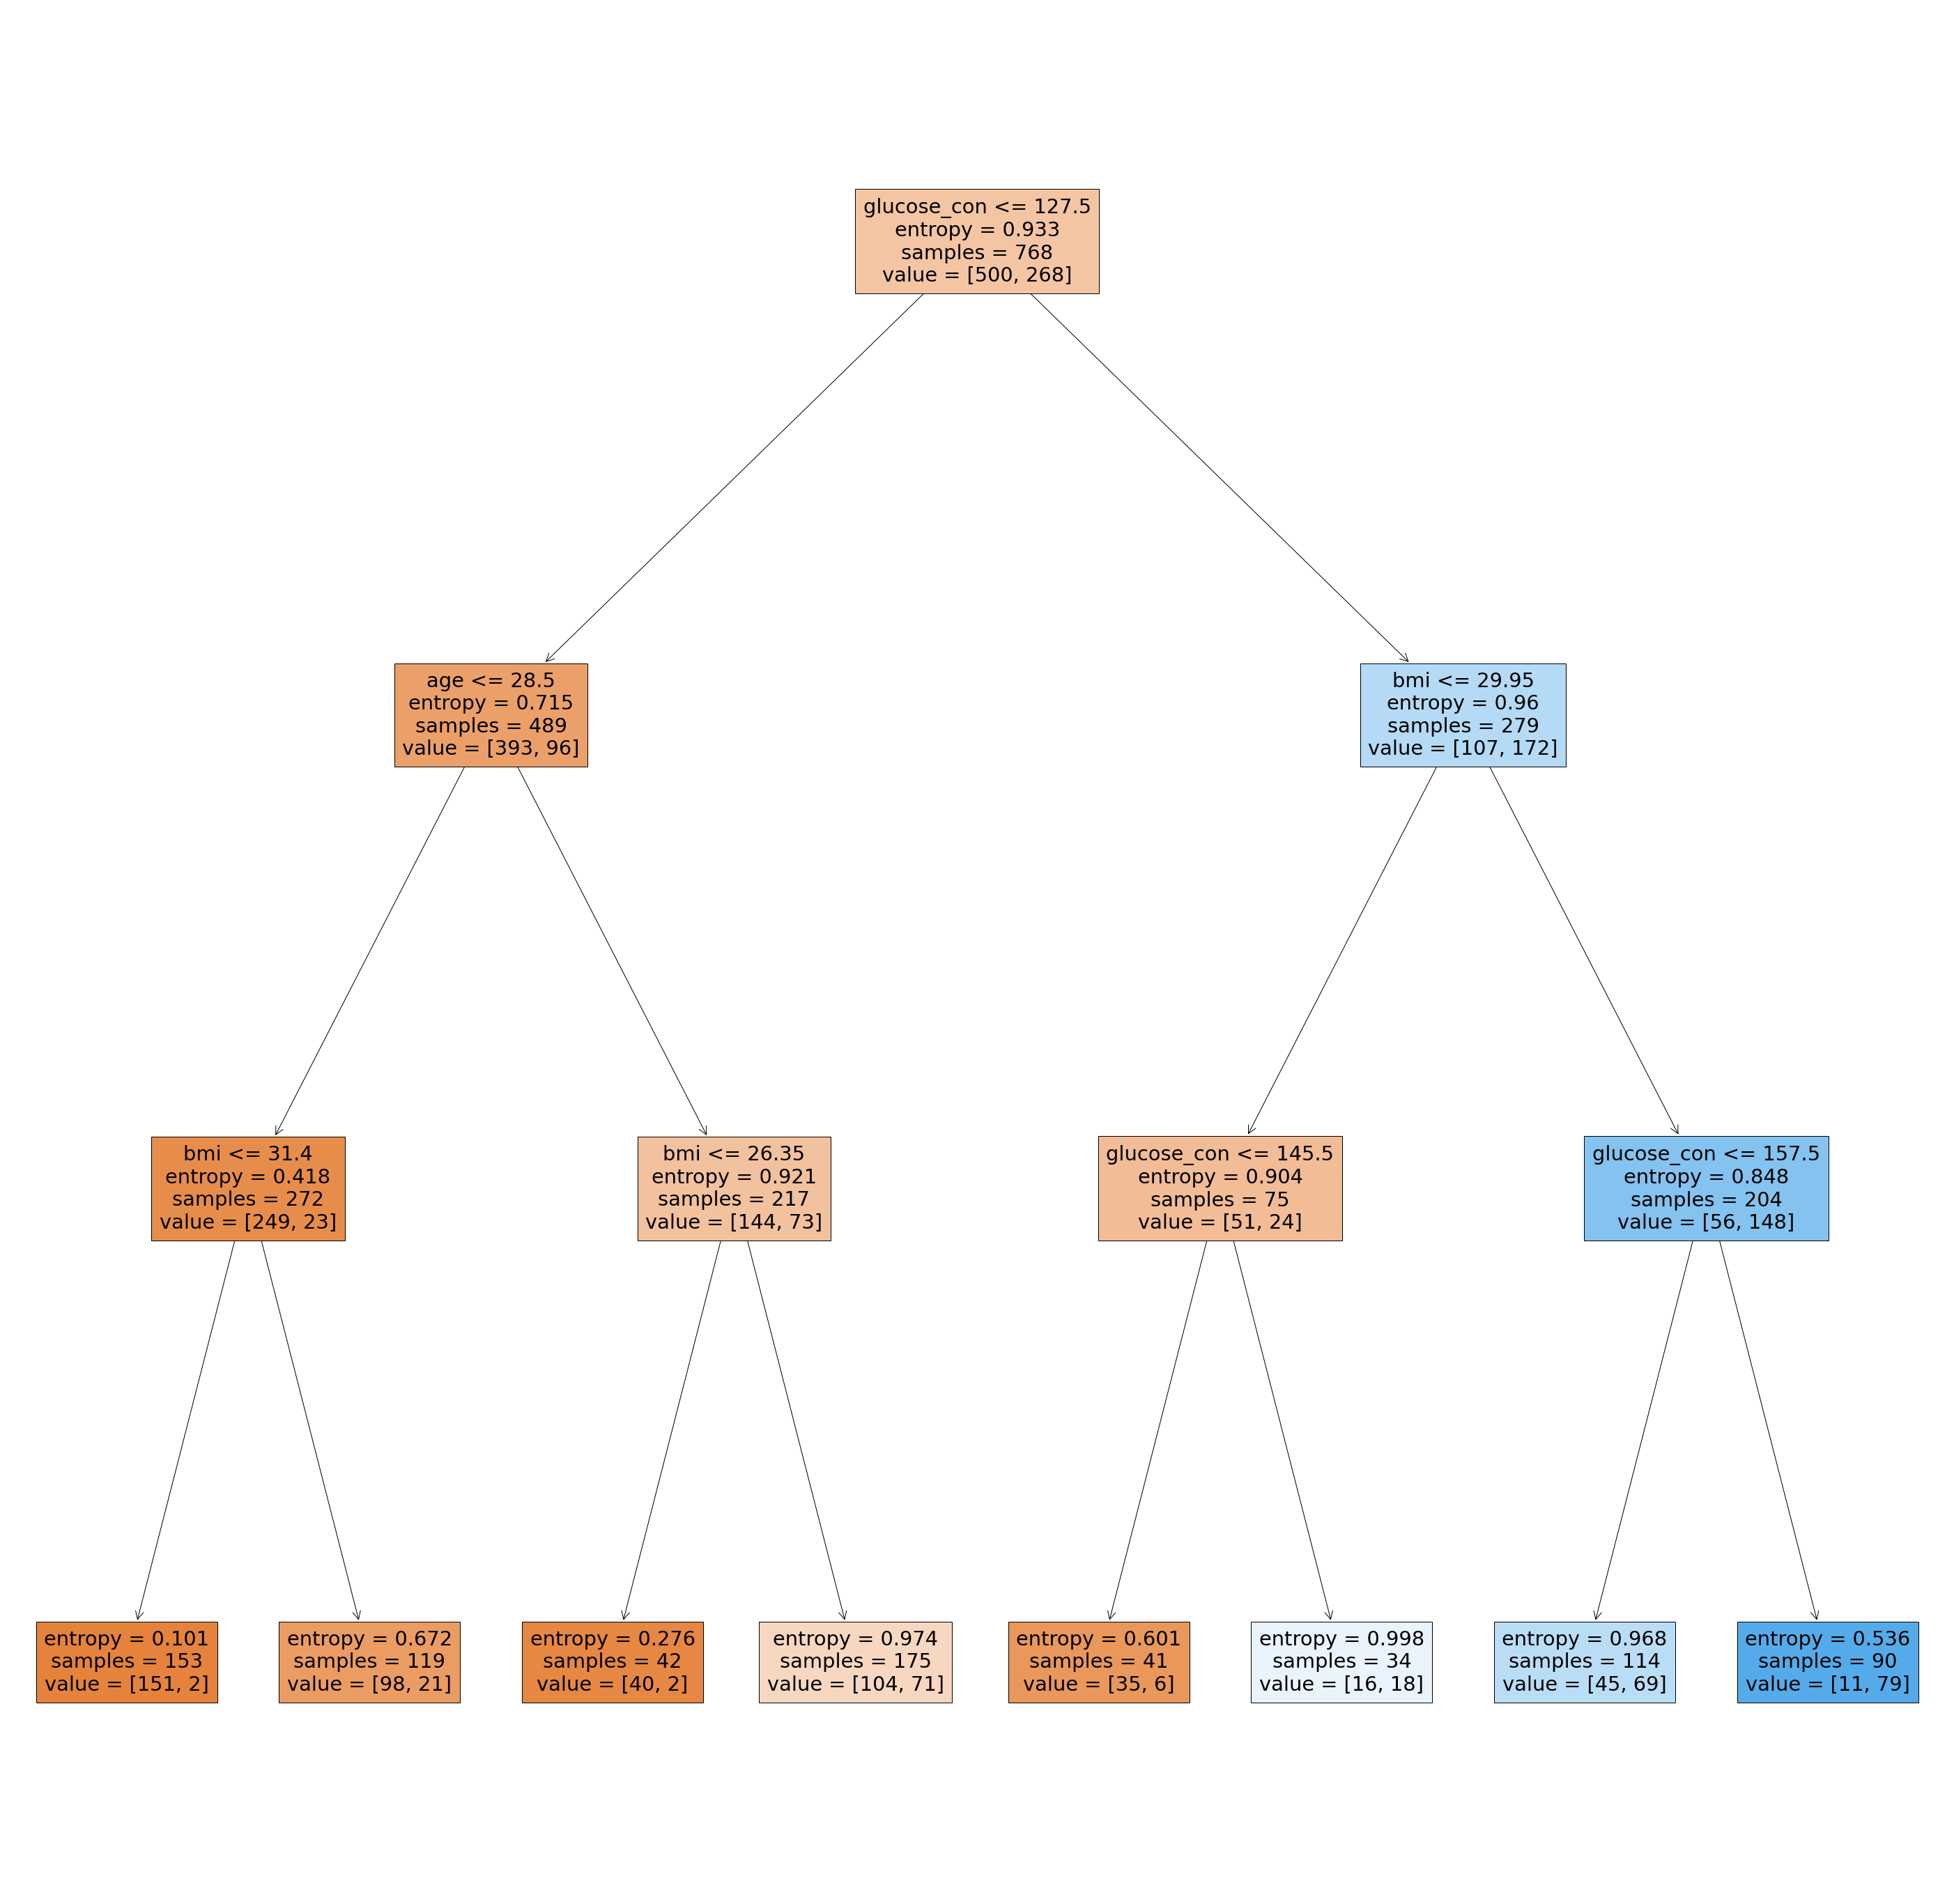

In [5]:
features = list(df.columns)
features.remove('diabetes')

X, y = df[features], df.diabetes

preprocessor = SimpleImputer(strategy='mean')
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])

model.fit(X,y)

plt.figure(figsize=(50, 50))

plot_tree(model.named_steps['classifier'], filled=True, feature_names=features)

plt.show()

Most tree-based methods are not sensitive to the scales of the variables, so scaling in this case is not necessary. 


'Samples' refers to the number of observations that fall in each splits, and 'Value' corresponds to the number of observations belonging to each class (i.e. value = [#ObservationsOfClass0, #ObservationsOfClass1]). 

For instance, a patient whose glucose concentration <= 127.5, whose age <= 28.5, and whose bmi <= 32.25 would fall in the most left-hand side leaf, and her class would be predicted as being 0 (diabetes negative) as the majority of observations that fall into that leaf do not have diabetes (162 0's against 3 1's). On the other hand, a patient whose glucose concentration > 154.5, and whose bmi > 29.85 would fall into the most right-hand side leaf, and her class would be predicted as 1 (diabetes positive). 

**3) Let's see how the model's performance evolve as a function of the tree's maximum depth.**

**To this end, split the dataset into a training and a test set following a 0.8/0.2 partition. Then, for maximum depths varying from 1 to 20, fit a Decision Tree classifier to the *training* data using a 10 folds cross-validation with the AUROC as metric. Plot the the means of the training and validation AUROCS across each folds as a function of the maximum depth. Also, compute the standard error of the means at each depth, and add it to the plot as shaded grey area around the means (cfr. plot below) . What can you conclude regarding the model's performance, as well as the uncertainty for the in-sample and out-of-sample AUROC estimates ?**

**Identify which depth would lead a priori to the best model's out-of-sample performance. Using this depth, fit a decision tree to the training split and report the training AUROC and the test AUROC.** 

<function matplotlib.pyplot.show>

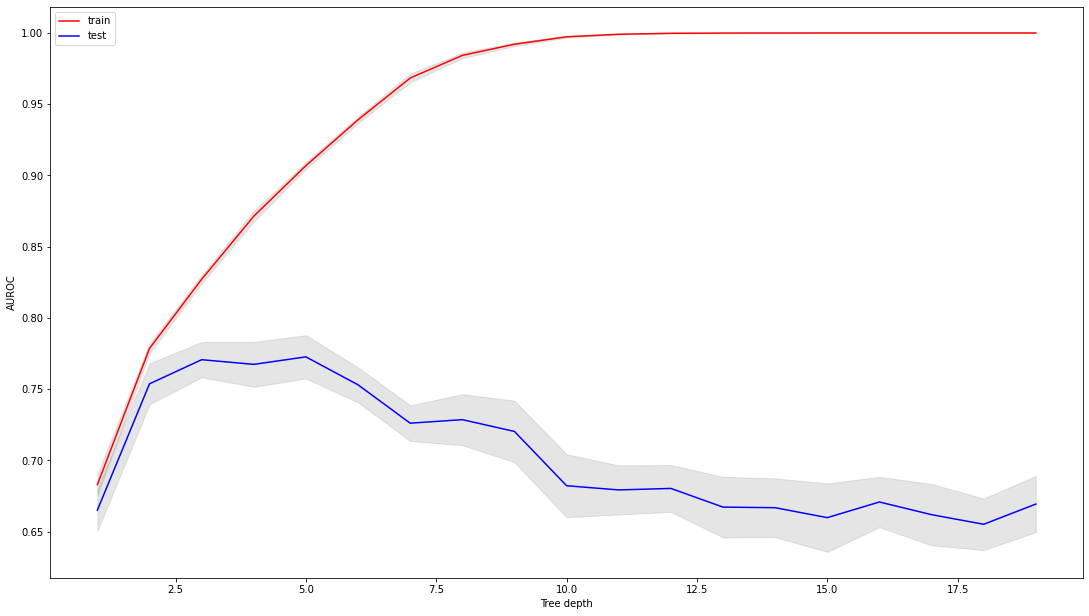

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

depths = np.arange(1,20)

train_score_mean, test_score_mean = [], []
train_score_se, test_score_se = [], []

for depth in depths:
  classifier = DecisionTreeClassifier(max_depth=depth)
  model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
  cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['roc_auc'], return_train_score=True)
  train_score = cv_results['train_roc_auc']
  test_score = cv_results['test_roc_auc']
  train_score_mean.append(train_score.mean())
  train_score_se.append(np.std(train_score)/math.sqrt(len(train_score)))
  test_score_mean.append(cv_results['test_roc_auc'].mean())
  test_score_se.append(np.std(test_score)/math.sqrt(len(test_score)))


fig, ax = plt.subplots()
ax.plot(depths, train_score_mean, label='train', color='red')
ax.fill_between(depths, np.array(train_score_mean) - train_score_se, np.array(train_score_mean) + train_score_se,
                 color='gray', alpha=0.2)
ax.fill_between(depths, np.array(test_score_mean) - test_score_se, np.array(test_score_mean) + test_score_se,
                 color='gray', alpha=0.2)
ax.plot(depths, test_score_mean, label='test', color='blue')
ax.set_xlabel('Tree depth')
ax.set_ylabel('AUROC')
ax.legend()
fig.set_size_inches(18.5, 10.5)
plt.show

Clearly, the decision tree starts overfitting very early as the maximum depth increases, shown by the increasing gap between the training and validation curves. 

The in-sample variance of a classifier quantifies by how much its predictions on the training data will vary when its fitted on different training sets. This is precisely what happens during cross-validation, as the same classifier's architecture is trained on different training sets, resulting in different models. The better the model fits the training data, the less error it makes when evaluated on it. This explains why the standard error is small for the training AUROC. In each fold, the model overfits the training data, and hence, its predictions do not vary much across folds. It goes up to the point where the model is complex enough to perfectly interpolate the training data (i.e. the model does not make mistakes on the training data). As in this case the training AUROC is equal to 1 in each fold, the standard error is null. 

On the other hand, the out-of-sample standard error seems to be slightly increasing when the model's complexity increases. This is direct consequence of overfitting. Indeed, as the models (in a 10 folds cross-validation, we have 10 different models) are extremely specific to the data they've been trained on, their predictions vary significantly when presented to unseen data (the validation fold), resulting in a high variance of validation AUROCS across the different folds, and hence, a large standard error.


In [11]:
best_depth_id = np.argmax(test_score_mean)
best_depth = depths[best_depth_id]
classifier = DecisionTreeClassifier(max_depth=best_depth)
model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
model.fit(X_train, y_train)
proba_train = model.predict_proba(X_train)[:,1]
proba_test = model.predict_proba(X_test)[:,1]
roc_train = roc_auc_score(y_train, proba_train)
roc_test = roc_auc_score(y_test, proba_test)

print('Best depth : {}'.format(best_depth))
print('Train AUROC : {}'.format(roc_train))
print('Test AUROC : {}'.format(roc_test))


Best depth : 5
Train AUROC : 0.9019615913821692
Test AUROC : 0.7696690179055887


# Bagging 

**4) Implement your own bagging algorithm by fitting a decision tree to each bootstrap sample. The bootstramp samples should be drawn from and of equal size as the training set. Set the the number of bootstrap samples to 30 and the maximum_depth of each decision as the optimum depth found above.**

**Then using the decision trees fitted on each bootsrapped training data, predict on the test set and use the majority vote strategy to get the final predictions. Redo the same by averaging the trees probabilities. Display the confusion matrix for the test set.**



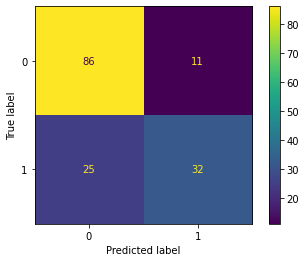

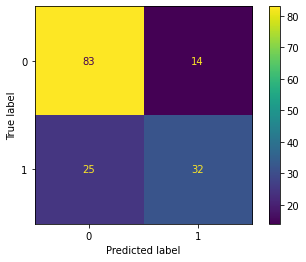

In [12]:
n = X_train.shape[0]
n_bags = 30

indices = [np.random.choice(a=n, size=n, replace=True) for _ in range(n_bags)]
classifier = DecisionTreeClassifier(max_depth=5)

bag_predictions, bag_proba = [], []
for idx in indices:
  model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
  X_bag, y_bag = X_train.iloc[idx,:], y_train.iloc[idx]
  model.fit(X_bag, y_bag)
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:,1]
  bag_predictions.append(y_pred)
  bag_proba.append(y_pred_proba)

bag_predictions = np.array(bag_predictions)
bagged_predictions_class = np.mean(bag_predictions, 0)
y_pred_bagged_class = [1 if prob >= 0.5 else 0 for prob in bagged_predictions_class]

bag_proba = np.array(bag_proba)
bagged_predictions_proba = np.mean(bag_proba, 0)
y_pred_bagged_proba = [1 if prob >= 0.5 else 0 for prob in bagged_predictions_proba]

cm_majority = confusion_matrix(y_test, np.array(y_pred_bagged_class))
cm_average_proba = confusion_matrix(y_test, np.array(y_pred_bagged_proba))

disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_majority)

disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_average_proba)


disp_1.plot()
disp_2.plot()


As observed, we can have different results when aggregating the predictions using either of the two strategies, as shown by the confusion matrices. 

# Random Forest

**5) Perform a random search on a specified grid of hyper-parameters to find the best hyper-parameters configuration for a RandomForestClassifier. Set the scoring function as the AUROC and limit the number of combination to try to 10.**

**Fit the best model found in the previous procedure to the training data, and predict on the test set. Report the test AUROC and display the ROC curve.**

In [13]:
param_grid = {
    'classifier__n_estimators' : [50,100,150,200],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [5,10,15,20,None],
    'classifier__max_features' : ['auto', 'sqrt', 'log2']
}

classifier = RandomForestClassifier()
model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=10, scoring='roc_auc', n_iter=10)
grid.fit(X_train, y_train)

best_params = grid.best_params_
best_model = grid.best_estimator_

Text(0.5, 1.0, 'Receiver Operating Curvee')

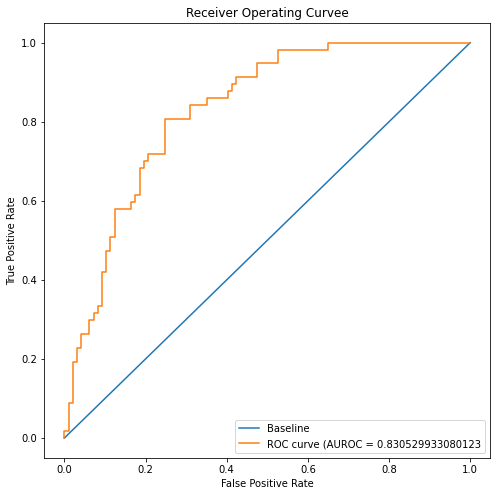

In [14]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

xaxis = np.arange(0,1.1,0.1)

ax.plot(xaxis, xaxis, label='Baseline')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

roc_auc = roc_auc_score(y_test, y_pred) 

ax.plot(fpr, tpr, label='ROC curve (AUROC = {}'.format(roc_auc))
ax.legend()
ax.set_title('Receiver Operating Curvee')


# Boosting

**7) Fit a boosting classifier to the training data, and report the training and test AUROC's. You can use the GradientBoostingClassifier from the sklearn library.**

In [15]:
classifier = GradientBoostingClassifier()
model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])

model.fit(X_train, y_train)

y_pred_train = model.predict_proba(X_train)[:,1]
y_pred_test = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

print('Train AUROC : {}'.format(auc_train))
print('Test AUROC : {}'.format(auc_test))


Train AUROC : 0.9786671057119001
Test AUROC : 0.8431904503526859


**8) For a decision tree classifier, a bagging classifier, a random forest classifier and a boosting classifier, perform a random search on a predifined grid of hyper-parameters. Amongst all models and hyper-parameters combinations, select the best model and report the best *validation* AUROC. The random search should be performed on the *training* data, and you can set the number of combinations to try per model to 5.**

**For the best model found, report the training and test AUROC's, and display the training and test ROC curves**

In [16]:
param_grid_boost = {
    'classifier__n_estimators' : [50,100,150,200],
    'classifier__learning_rate' : [0.5, 0.1, 0.05],
    'classifier__min_samples_split' : [2,5,10],
    'classifier__min_samples_leaf' : [2,5,10]
}

param_grid_bag = {
    'classifier__n_estimators' : [50,100,150,200],
}

param_grid_tree = {
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [None, 2,5,10],
    'classifier__min_samples_split' : [2,5,10],
    'classifier__min_samples_leaf' : [2,5,10]
}


param_grid_forest = {
    'classifier__n_estimators' : [50,100,150,200],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [5,10,15,20,None],
    'classifier__max_features' : ['auto', 'sqrt', 'log2']
}

boost = GradientBoostingClassifier()
tree = DecisionTreeClassifier()
bag = BaggingClassifier()
forest = RandomForestClassifier()

classifiers = [boost, bag, tree, forest]
grids = [param_grid_boost, param_grid_bag, param_grid_tree, param_grid_forest]

best_results_list = []
best_estimators_list = []
for i, grid in enumerate(grids):
  print(classifiers[i])
  model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifiers[i])])
  grid = RandomizedSearchCV(estimator=model, param_distributions=grid, cv=10, scoring='roc_auc', n_iter=5)
  grid.fit(X_train, y_train)
  best_results_list.append(grid.cv_results_['mean_test_score'].max())
  best_estimators_list.append(grid.best_estimator_)

GradientBoostingClassifier()
BaggingClassifier()


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


DecisionTreeClassifier()
RandomForestClassifier()


In [17]:
print('Best model : {}'.format(best_estimators_list[np.argmax(best_results_list)]))
print('Best validation AUROC : {}'.format(max(best_results_list)))

Best model : Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        n_estimators=150))])
Best validation AUROC : 0.8330507602153944


Text(0.5, 1.0, 'Receiver Operating Curvee')

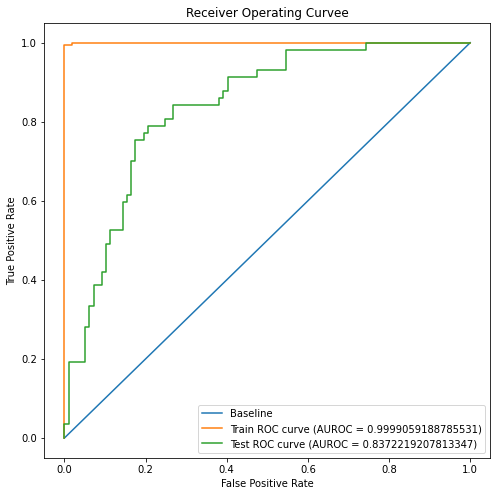

In [18]:
best_estimator = best_estimators_list[np.argmax(best_results_list)]

best_estimator.fit(X_train, y_train)

y_pred_train = best_estimator.predict_proba(X_train)[:,1]
y_pred_test = best_estimator.predict_proba(X_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test, pos_label=1)


fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

xaxis = np.arange(0,1.1,0.1)

ax.plot(xaxis, xaxis, label='Baseline')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

roc_auc_train = roc_auc_score(y_train, y_pred_train) 
roc_auc_test = roc_auc_score(y_test, y_pred_test) 

ax.plot(fpr_train, tpr_train, label='Train ROC curve (AUROC = {})'.format(roc_auc_train))
ax.plot(fpr_test, tpr_test, label='Test ROC curve (AUROC = {})'.format(roc_auc_test))
ax.legend()
ax.set_title('Receiver Operating Curvee')

The ROC obtained by evaluating the model on the training data is very close to the one of a perfect classifier (i.e. AUROC = 1). The model overfits then training data. 

# Regression 

**9) Select 'bmi' as the target variable and all the remaining columns in the dataframe as the predictors. Split your dataset into a training and test set, fit a decision tree regressor to the training data, and report the MSE on the training and test sets. What do you observe ?**

In [19]:
features = list(df.columns)
features.remove('bmi')

X, y = df[features], df.bmi

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2)

regressor = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test  = mean_squared_error(y_pred_test, y_test)

print('Train MSE : {}'.format(mse_train))
print('Test MSE : {}'.format(mse_test))

Train MSE : 0.0
Test MSE : 87.4488961038961


As we did not impose any restrictions on the depth that the tree could reach, it grew to the point that each leaf contains a single training observation. The value predicted for a leaf being the mean of the observations contained in it, and as each leaf contains a single observation, the model exactly predicts all training points, and the MSE is null. The behaviour obviously does not generalize well, as shown by the test MSE. 

**10) For a decision tree regressor, a bagging regressor, a random forest regressor and a boosting regressor, perform a random search on a predifined grid of hyper-parameters. Amongst all models and hyper-parameters combinations, select the best model and report the best *validation* MSE. The random search should be performed on the *training* data, and you can set the number of combinations to try per model to 5.**

**For the best model found, report the training and test MSE.**

In [20]:
param_grid_boost = {
    'classifier__n_estimators' : [50,100,150,200],
    'classifier__learning_rate' : [0.5, 0.1, 0.05],
    'classifier__min_samples_split' : [2,5,10],
    'classifier__min_samples_leaf' : [2,5,10]
}

param_grid_bag = {
    'classifier__n_estimators' : [50,100,150,200],
}

param_grid_tree = {
    'classifier__criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'classifier__max_depth' : [None, 2,5,10],
    'classifier__min_samples_split' : [2,5,10],
    'classifier__min_samples_leaf' : [2,5,10]
}


param_grid_forest = {
    'classifier__n_estimators' : [50,100,150,200],
    'classifier__criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'classifier__max_depth' : [5,10,15,20,None],
    'classifier__max_features' : ['auto', 'sqrt', 'log2']
}

boost = GradientBoostingRegressor()
tree = DecisionTreeRegressor()
bag = BaggingRegressor()
forest = RandomForestRegressor()

classifiers = [boost, bag, tree, forest]
grids = [param_grid_boost, param_grid_bag, param_grid_tree, param_grid_forest]

best_results_list = []
best_estimators_list = []
for i, grid in enumerate(grids):
  print(classifiers[i])
  model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifiers[i])])
  grid = RandomizedSearchCV(estimator=model, param_distributions=grid, cv=10, scoring='neg_mean_squared_error', n_iter=5)
  grid.fit(X_train, y_train)
  best_results_list.append(-grid.cv_results_['mean_test_score'].max())
  best_estimators_list.append(grid.best_estimator_)

GradientBoostingRegressor()
BaggingRegressor()


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


DecisionTreeRegressor()
RandomForestRegressor()


In [21]:
print('Best model : {}'.format(best_estimators_list[np.argmax(best_results_list)]))
print('Best validation MSE : {}'.format(max(best_results_list)))

Best model : Pipeline(steps=[('preprocessor', SimpleImputer()),
                ('classifier',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=5))])
Best validation MSE : 44.294656981702914


In [22]:
best_estimator = best_estimators_list[np.argmax(best_results_list)]

best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)

test_mse = mean_squared_error(y_pred, y_test)

print('Test MSE : {}'.format(test_mse))

Test MSE : 51.73992605202454
